<a href="https://colab.research.google.com/github/shafakhadijah/DeepLearningTask/blob/main/TaskWeek5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Shafa Khadijah Rahmat

NPM: 2306319496

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.1 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uni

# 9.1 Working with Sequences

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

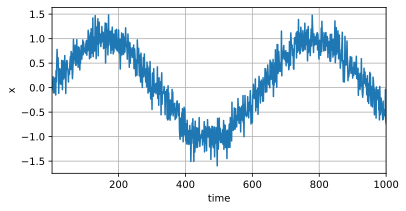

In [ ]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

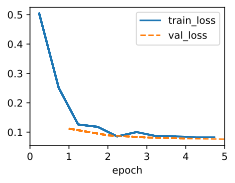

In [ ]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

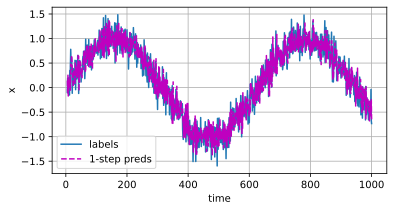

In [ ]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

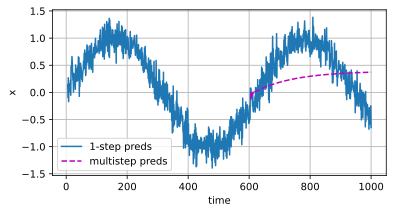

In [ ]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

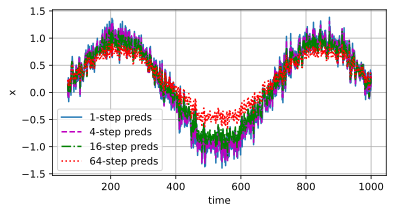

In [ ]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

9.1.6 Exercises

1. Meningkatkan model dalam eksperimen:

  1.1. Menggunakan lebih dari 4 observasi masa lalu memungkinkan model untuk menangkap lebih banyak pola, tetapi jumlah optimal tergantung pada kompleksitas data. Tes empiris diperlukan untuk menentukan jumlah past observasi yang ideal.

  1.2. Tanpa noise, jumlah observasi bisa dihitung dari periode sinyal. Dengan merepresentasikan fungsi sinus dan kosinus sebagai persamaan diferensial, kita bisa mengurangi jumlah observasi.

  1.3. Anda bisa menggabungkan observasi lama dengan menggunakan teknik seperti embedding, sehingga jumlah fitur tetap konstan. Ini bisa meningkatkan akurasi dengan menangkap dependensi jangka panjang.

  1.4. Mengubah arsitektur jaringan, misalnya dengan menambah layer atau unit, dan melatih lebih lama dapat meningkatkan performa, namun juga bisa menyebabkan overfitting.

2. Strategi investor: Melihat hanya data historis tanpa mempertimbangkan variabel lain bisa menyesatkan karena return masa lalu tidak selalu memprediksi performa masa depan.

3. Kausalitas pada teks: Dalam teks, urutan kata atau kalimat sangat penting, sehingga kausalitas bisa diterapkan. Namun, derajat kausalitas bisa lebih fleksibel dibanding data waktu.

4. Model autoregresif laten: Misalnya, untuk data ekonomi yang bergantung pada tren tersembunyi, seperti pengaruh sentimen pasar atau faktor musiman yang tidak langsung terlihat dari data observasi.

# 9.2 Converting Raw Text into Sequence Data

In [ ]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [ ]:
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [ ]:
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

In [ ]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [ ]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [ ]:
@d2l.add_to_class(TimeMachine)
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [ ]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

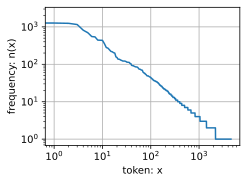

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [ ]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [ ]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

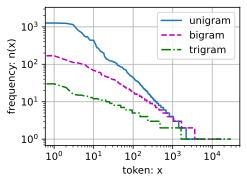

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

9.2.7. Exercises

1. Vary min_freq pada Vocab: Dengan menaikkan nilai min_freq, kosakata yang jarang muncul akan dikeluarkan dari daftar. Ini mengurangi ukuran kosakata dan membuat model lebih fokus pada kata yang sering muncul. Sebaliknya, jika min_freq lebih rendah, lebih banyak kata akan disertakan dalam kosakata.

2. Estimasi eksponen distribusi Zipf: Distribusi Zipfian mengikuti pola bahwa kata yang paling sering muncul jauh lebih sering daripada yang jarang. Anda dapat menghitung eksponen distribusi Zipfian untuk unigram, bigram, dan trigram dari data, lalu mengestimasi eksponennya dengan log-log plot frekuensi kata terhadap peringkat.

3. Sumber data lain: Setelah mengunduh dataset lain, lakukan tokenisasi pada tingkat kata dan karakter. Bandingkan ukuran kosakata dengan "The Time Machine" pada nilai min_freq yang sama, serta hitung eksponen Zipfian untuk unigram dan bigram. Hasilnya bisa bervariasi tergantung pada sifat data (misalnya, teks ilmiah mungkin memiliki kosakata yang lebih bervariasi dibanding teks fiksi).

# 9.3 Language Models

In [ ]:
import torch
from d2l import torch as d2l

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [26]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[10,  4, 21, 13, 26,  0,  4, 16, 14, 14],
        [15, 21, 19, 16, 20, 17,  6,  4, 21, 10]]) 
Y: tensor([[ 4, 21, 13, 26,  0,  4, 16, 14, 14, 22],
        [21, 19, 16, 20, 17,  6,  4, 21, 10, 23]])


9.3.5 Exercises

1. Frekuensi yang disimpan untuk four-gram: Jika terdapat 100.000 kata dalam dataset, four-gram harus menyimpan frekuensi setiap urutan 4 kata berturut-turut. Ini menghasilkan total kemungkinan kombinasi sebesar 100.000^4, tetapi dalam praktiknya hanya sebagian kecil yang digunakan, karena banyak urutan tidak muncul.

2. Model dialog: Anda bisa menggunakan model sequence-to-sequence (seq2seq) dengan perhatian (attention) atau model transformer. Model ini menangani konteks dan respons dengan baik untuk data percakapan.

3. Metode untuk membaca data urutan panjang: Selain RNN dan LSTM, Anda bisa menggunakan Transformer atau pendekatan sliding window, di mana data dipecah menjadi potongan-potongan dan diproses secara bertahap.

4. Membuang token secara acak di awal epoch:

  4.1. Tidak menghasilkan distribusi yang sepenuhnya seragam karena urutan lebih pendek atau lebih panjang dari jendela yang diinginkan mungkin tidak tercakup secara sempurna.

  4.2. Untuk distribusi yang lebih seragam, Anda bisa mengacak titik awal dengan lebih presisi, misalnya dengan menyesuaikan probabilitas berdasarkan panjang urutan.

5. Minibatch sampling untuk kalimat lengkap: Jika ingin setiap contoh urutan menjadi kalimat lengkap, masalah muncul karena panjang kalimat bervariasi, membuat minibatch menjadi tidak seragam. Solusi adalah padding atau bucket sampling, di mana data dikelompokkan berdasarkan panjangnya untuk meminimalkan padding.

# 9.4 Recurrent Neural Networks

In [27]:
import torch
from d2l import torch as d2l

In [28]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-1.5589,  3.5179, -1.3013,  0.2963],
        [ 1.4054,  2.4802, -3.6113, -2.1242],
        [ 0.2274,  1.7533, -1.8899,  0.9509]])

In [29]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-1.5589,  3.5179, -1.3013,  0.2963],
        [ 1.4054,  2.4802, -3.6113, -2.1242],
        [ 0.2274,  1.7533, -1.8899,  0.9509]])

9.4.5 Exercises

1. Dimensi output RNN untuk prediksi karakter berikutnya: Dimensinya sama dengan jumlah karakter unik dalam kosakata (vocabulary) karena setiap output mewakili probabilitas distribusi atas semua karakter.

2. RNN mengekspresikan probabilitas bersyarat: RNN menyimpan informasi dari setiap token sebelumnya melalui hidden state, sehingga bisa menangkap dependensi urutan dan memperkirakan probabilitas bersyarat berdasarkan seluruh urutan sebelumnya.

3. Gradien dalam urutan panjang: Gradien bisa mengalami masalah vanishing (menghilang) atau exploding (meledak), menyebabkan pembelajaran menjadi tidak stabil atau tidak efektif pada urutan panjang.

4. Masalah model bahasa: Beberapa masalah adalah long-term dependency yang sulit ditangkap RNN, serta tantangan dalam melatih jaringan pada urutan panjang karena masalah gradien

# 9.5 Recurrent Neural Network Implementation from Scratch

In [30]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [31]:
class RNNScratch(d2l.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [32]:
@d2l.add_to_class(RNNScratch)
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [33]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [34]:
def check_len(a, n):
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [35]:
class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [36]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [37]:
@d2l.add_to_class(RNNLMScratch)
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

In [38]:
@d2l.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [39]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [40]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

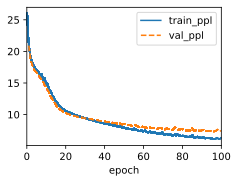

In [41]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [42]:
@d2l.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [43]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has anout a mone war a '

9.5.7 Exercises

1. Model bahasa RNN: Model ini memprediksi token berikutnya berdasarkan sejumlah token sebelumnya, tetapi tidak semua token dari awal (karena keterbatasan panjang urutan yang diproses dalam minibatch).

2. Hyperparameter untuk panjang sejarah: Jumlah langkah waktu (time steps) dalam minibatch menentukan berapa banyak token sebelumnya yang dipertimbangkan.

3. One-hot encoding vs embedding: One-hot encoding adalah bentuk khusus dari embedding, di mana setiap objek dipetakan ke sebuah vektor sparse dengan satu nilai "1" pada posisi tertentu.

4. Menyesuaikan hyperparameter: Dengan menambah jumlah epoch, hidden units, time steps, dan menyesuaikan learning rate, Anda bisa mengurangi perplexity. Hasilnya tergantung eksperimen spesifik.

5. Menggantikan one-hot dengan embedding: Menggunakan embedding yang dapat dipelajari biasanya meningkatkan performa karena memungkinkan model untuk mempelajari representasi yang lebih kaya dari data.

6. Eksperimen pada buku lain oleh H.G. Wells: Melatih model pada "The Time Machine" mungkin tidak bekerja sebaik pada "The War of the Worlds" karena gaya penulisan bisa berbeda, namun dapat memberikan wawasan tentang generalisasi model.

7. Eksperimen pada buku penulis lain: Melakukan eksperimen dengan buku dari penulis lain dapat menunjukkan apakah model dapat generalisasi, atau apakah hanya bekerja baik pada teks dari penulis tertentu.

8. Menggunakan sampling untuk prediksi:

  8.1. Menggunakan sampling memberikan variasi yang lebih besar dalam output, meskipun mungkin lebih tidak stabil.

  8.2. Anda dapat bias sampling untuk lebih cenderung memilih token yang lebih mungkin dengan menaikkan probabilitas sesuai eksponen alpha.

9. Tanpa gradient clipping: Tanpa clipping, gradien bisa "meledak" dalam urutan panjang, menyebabkan pembelajaran tidak stabil.

10. Mengganti fungsi aktivasi dengan ReLU: ReLU sering kali membutuhkan gradient clipping lebih sedikit karena masalah gradien meledak cenderung lebih kecil dibandingkan dengan fungsi sigmoid atau tanh, tetapi tergantung pada panjang urutan dan ukuran gradien.

# 9.6 Concise Implementation of Recurrent Neural Networks

In [44]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [45]:
class RNN(d2l.Module):
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [46]:
class RNNLM(d2l.RNNLMScratch):
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [47]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hascccccccccccccccccccc'

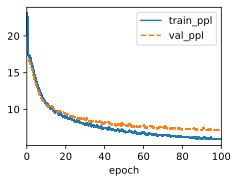

In [48]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [49]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the the the the'

9.6.4 Exercises

1. Membuat RNN overfit: Ya, bisa membuat model RNN overfit dengan menggunakan API tingkat tinggi. Ini bisa dilakukan dengan melatih model terlalu lama (banyak epoch) tanpa cukup regularisasi, seperti drop out atau early stopping, sehingga model hanya belajar pola pada data latih dan tidak dapat generalisasi ke data uji.

2. Mengimplementasikan model autoregresif menggunakan RNN: Anda bisa menerapkan model autoregresif dengan RNN yang memprediksi nilai berikutnya berdasarkan urutan input sebelumnya, mirip dengan bagaimana RNN biasanya digunakan untuk tugas urutan waktu atau teks.

Kerangka umum implementasi:

import torch

import torch.nn as nn

class RNNModel(nn.Module):


    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):  
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
         x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

# 9.7 Backpropagation Through Time

9.7.4 Exercises

1.

1.1. Tunjukkan bahwa 𝑀 𝑘 M k memiliki nilai eigen 𝜆 𝑖 𝑘 λ i k​

Untuk membuktikan bahwa 𝑀 𝑘 M k memiliki nilai eigen 𝜆 𝑖 𝑘 λ i k​, kita dapat menggunakan sifat dari nilai eigen dan vektor eigen. Misalkan 𝑀 M adalah matriks simetris dengan nilai eigen 𝜆 𝑖 λ i​dan vektor eigen 𝑣 𝑖 v i​. Dari definisi, kita tahu bahwa:

    𝑀 𝑣 𝑖 = 𝜆 𝑖 𝑣 𝑖 Mv i​=λ i​v i​

Ketika kita mengalikan 𝑀 M dengan dirinya sendiri 𝑘 k kali, kita dapat menulis:

    𝑀 2 𝑣 𝑖 = 𝑀 ( 𝑀 𝑣 𝑖 ) = 𝑀 ( 𝜆 𝑖 𝑣 𝑖 ) = 𝜆 𝑖 ( 𝑀 𝑣 𝑖 ) = 𝜆 𝑖 ( 𝜆 𝑖 𝑣 𝑖 ) = 𝜆 𝑖 2 𝑣 𝑖 M 2 v i​=M(Mv i​)=M(λ i​v i​)=λ i​(Mv i​)=λ i​(λ i​v i​)=λ i 2​v i​

Dengan induksi, kita dapat menunjukkan bahwa untuk setiap 𝑘 k:

    𝑀 𝑘 𝑣 𝑖 = 𝜆 𝑖 𝑘 𝑣 𝑖 M k v i​=λ i k​v i​

    Jadi, 𝜆 𝑖 𝑘 λ i k​adalah nilai eigen dari 𝑀 𝑘 M k .

1.2. Buktikan bahwa untuk vektor acak 𝑥 ∈ 𝑅 𝑛 x∈R n dengan probabilitas tinggi, 𝑀 𝑘 𝑥 M k x akan sangat selaras dengan vektor eigen 𝑣 1 v 1​dari 𝑀 M. Formalisasikan pernyataan ini.

Misalkan 𝑥 x adalah vektor acak dalam ruang 𝑅 𝑛 R n . Kita dapat mengekspresikan 𝑥 x sebagai kombinasi linier dari vektor eigen 𝑣 𝑖 v i​:

    𝑥 = ∑ 𝑖 = 1 𝑛 𝑎 𝑖 𝑣 𝑖 x= i=1 ∑ n​a i​v i​

Ketika kita menerapkan 𝑀 𝑘 M k pada 𝑥 x:

    𝑀 𝑘 𝑥 = 𝑀 𝑘 ( ∑ 𝑖 = 1 𝑛 𝑎 𝑖 𝑣 𝑖 ) = ∑ 𝑖 = 1 𝑛 𝑎 𝑖 𝑀 𝑘 𝑣 𝑖 = ∑ 𝑖 = 1 𝑛 𝑎 𝑖 𝜆 𝑖 𝑘 𝑣 𝑖 M k x=M k ( i=1 ∑ n​a i​v i​)= i=1 ∑ n​a i​M k v i​= i=1 ∑ n​a i​λ i k​v i​

Ketika 𝑘 k meningkat, nilai eigen ∣ 𝜆 1 ∣ 𝑘 ∣λ 1​∣ k akan mendominasi nilai-nilai eigen lainnya, mengingat ∣ 𝜆 1 ∣ ≥ ∣ 𝜆 2 ∣ ≥ … ≥ ∣ 𝜆 𝑛 ∣ ∣λ 1​∣≥∣λ 2​∣≥…≥∣λ n​∣. Oleh karena itu, untuk nilai 𝑘 k yang cukup besar, komponen dari 𝑣 1 v 1​akan mendominasi 𝑀 𝑘 𝑥 M k x:

    𝑀 𝑘 𝑥 ≈ 𝑎 1 𝜆 1 𝑘 𝑣 1 M k x≈a 1​λ 1 k​v 1​

Dengan probabilitas tinggi, kita dapat mengatakan bahwa:

    lim ⁡ 𝑘 → ∞ 𝑀 𝑘 𝑥 ∣ ∣ 𝑀 𝑘 𝑥 ∣ ∣ ≈ 𝑣 1 ∣ ∣ 𝑣 1 ∣ ∣ k→∞ lim​

    ∣∣M k x∣∣ M k x​≈ ∣∣v 1​∣∣ v 1​

​

Ini menunjukkan bahwa 𝑀 𝑘 𝑥 M k x akan sangat selaras dengan 𝑣 1 v 1​.

1.3. Apa arti hasil di atas untuk gradien dalam RNN?

Hasil di atas menunjukkan bahwa saat 𝑘 k meningkat, gradien yang dihitung dalam RNN akan sangat terpengaruh oleh vektor eigen 𝑣 1 v 1​, yang berhubungan dengan nilai eigen terbesar 𝜆 1 λ 1​. Hal ini dapat menyebabkan fenomena yang dikenal sebagai "vanishing gradient" atau "exploding gradient". Dalam konteks RNN, jika ∣ 𝜆 1 ∣

    1 ∣λ 1​∣>1, gradien akan meledak (exploding) dan jika ∣ 𝜆 1 ∣ < 1 ∣λ 1​∣<1, gradien akan mengecil (vanishing).
    Ini berarti bahwa gradien untuk bagian awal dari urutan mungkin menjadi sangat kecil atau besar, yang membuat pelatihan model menjadi sulit dan tidak stabil.

2. Selain pemotongan gradien (gradient clipping), beberapa metode lain untuk mengatasi exploding gradient dalam jaringan saraf berulang (RNN) meliputi:
Penggunaan Arsitektur LSTM atau GRU: Long Short-Term Memory (LSTM) dan Gated Recurrent Units (GRU) dirancang untuk mengatasi masalah vanishing dan exploding gradient dengan mekanisme gerbang yang mengatur aliran informasi.

  Normalisasi Batch (Batch Normalization): Menggunakan normalisasi batch pada setiap langkah waktu dapat membantu menstabilkan distribusi gradien, yang mengurangi masalah exploding gradient.

  Inisialisasi Bobot yang Tepat: Memilih metode inisialisasi bobot yang baik, seperti He atau Glorot, dapat membantu mengurangi risiko exploding gradient.

  Regularisasi: Menggunakan teknik regularisasi seperti dropout pada langkah-langkah waktu dapat membantu mencegah overfitting dan menjaga gradien tetap stabil.

  Dengan menggunakan metode ini, kita dapat memperbaiki pelatihan RNN dan menjaga stabilitas gradien.